In [2]:
%matplotlib inline
import math
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import sys
sys.path.append("../")
from pltutils import *
BATCH_SIZE,NUM_STEPS=32,35
train_iter,vocab=load_data_time_machine(BATCH_SIZE,NUM_STEPS)

In [3]:
# 获取独热编码
F.one_hot(t.tensor([0,2]),len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [4]:
# 我们每次采样的Batch数据是二维的张量(B,T)，之后将这种批量数据转换成三维张量，最后一个维度等于词表大小V，我们经常转换输入的
#维度，以便获得形状为(T,B,V)的输出，这样就能更加方便的通过最外层的维度一步一步的更新小批量数据的隐状态
X=t.arange(10).reshape((2,5))
F.one_hot(X.T,28).shape


torch.Size([5, 2, 28])

In [5]:
F.one_hot(X.T,28)

tensor([[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0

In [6]:
#初始化模型参数
def get_params(vocab_size,num_hiddens,device):
    num_inputs= num_outputs=vocab_size

    def normal(shape):
        return t.randn(size=shape,device=device)*0.01
    #隐藏层参数
    W_xh=normal((num_inputs,num_hiddens))
    W_hh=normal((num_hiddens,num_hiddens))
    b_h=t.zeros(num_hiddens,device=device)
    #输出层参数
    W_hq=normal((num_hiddens,num_outputs))
    b_q=t.zeros(num_outputs,device=device)
    #附加梯度
    params=[W_xh,W_hh,b_h,W_hq,b_q]
    for param in params:
        param.requires_grad_(True)
    return params


In [7]:
# 定义init rnn state函数在初始化时候返回隐状态，函数的返回是一个张量，用全0填充
def init_rnn_state(batch_size:int,num_hidens:int,device:t.device):
    return (t.zeros((batch_size,num_hidens),device=device),)

In [8]:
# 定义RNN模型
def rnn(inputs,state,params:list[t.Tensor]):
    # input.shape = (T,B,V)
    W_xh,W_hh,b_h,W_hq,b_q=params
    H,=state
    outputs=[]
    #X.shape = (B,V)
    for X in inputs:
        H=t.tanh(t.mm(X,W_xh)+t.mm(H,W_hh)+b_h)
        Y=t.mm(H,W_hq)+b_q
        outputs.append(Y)
    return t.cat(outputs,dim=0),(H,)

# 创建RNN类，存储相关参数

In [9]:
class RNNModelScratch:
    def __init__(self,vocab_size,num_hiddens,device:t.device,get_params,init_state,forward_fn):
        self.vocab_size=vocab_size
        self.num_hiddens=num_hiddens
        self.params=get_params(vocab_size,num_hiddens,device)
        self.init_state=init_state
        self.forward_fn=forward_fn
    
    def __call__(self,X:t.Tensor,state:t.Tensor):
        X=F.one_hot(X.T,self.vocab_size).type(t.float32)
        return self.forward_fn(X,state,self.params)

    def begin_state(self,batch_size,device:t.device):
        return self.init_state(batch_size,self.num_hiddens,device)

In [10]:
# 检查输入输出
num_hiddens=512
net = RNNModelScratch(len(vocab),num_hiddens,try_gpu(),get_params,init_rnn_state,rnn)
state=net.begin_state(X.shape[0],try_gpu())
Y,new_state=net(X.to(try_gpu()),state)
Y.shape,len(new_state),new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

# Prediction

In [11]:
def predict_ch8(prefix,num_preds,net:RNNModelScratch,vocab:Vocab,device:t.device):
    state=net.begin_state(batch_size=1,device=device)
    outputs=[vocab[prefix[0]]]
    get_input=lambda :t.tensor([outputs[-1]],device=device).reshape((1,1))
    # 预热
    for y in prefix[1:]:
        _,state=net(get_input(),state)
        outputs.append(vocab[y])
    # 进行预测
    for _ in range(num_preds):
        y,state=net(get_input(),state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return "".join([vocab.idx_to_token[i] for i in outputs])
predict_ch8('time traveller ', 10, net, vocab, try_gpu())

'time traveller evbjkhgi<unk>n'

# 梯度裁剪
对于长度为**T**的序列，在迭代中计算**T**个时间步上的梯度,会在反向传播过程中产生长度为$\mathcal {O}(T)$的矩阵乘法链，T较大的时候会导致不稳定，所以需要进行梯度裁剪

梯度很大的时候，优化算法可能无法收敛，虽然可以通过降低$\eta$来解决这个问题，但是如果很少获得较大的梯度的时候，这种做法会导致训练很慢，一个流行的替代方案是将梯度$\mathbf{g}$投影回给定半径的球来裁剪梯度$\mathbf{g}$，如下式子：
$$\mathbf{g} \leftarrow \min \left (1, \frac {\theta} {\|\mathbf{g}\|}\right) \mathbf{g}$$

通过这样做，我们可以知道梯度范数永远不会超过$\mathbf{\theta}$并且更新之后的梯度完全与g的原始方向对齐。

In [12]:
def grad_clipping(net,theta):
    if isinstance(net,nn.Module):
        params= [p for p in net.parameters() if p.requires_grad]
    else:
        params=net.params
    norm=t.sqrt(sum(t.sum((p.grad**2)) for p in params))
    if norm>theta:
        for param in params:
            param.grad[:]*=theta/norm

# 训练函数

In [13]:
def train_epoch_ch8(net,train_iter,loss,updater,device,use_random_iter):
    state,timer =None,Timer()
    metric=Accumulator(2)
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

def train_ch8(net,train_iter,vocab,lr,num_epochs,device,use_random_iter=False):
    loss=nn.CrossEntropyLoss()
    animator = Animator(xlabel='epoch', ylabel='perplexity',
                        legend=['train'], xlim=[10, num_epochs])
    
    # init
    if isinstance(net,nn.Module):
        updater=t.optim.SGD(net.parameters(),lr)
    else:
        updater= lambda batch_size:sgd(net.params,lr,batch_size)
    predict = lambda prefix:predict_ch8(prefix,50,net,vocab,device)
    #训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch+1)%10==0:
            print(predict("time traveller"))
            animator.add(epoch+1,[ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))


困惑度 1.0, 71899.0 词元/秒 cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


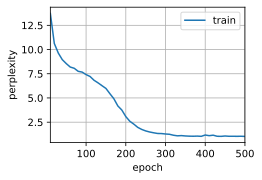

In [14]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, try_gpu())
